# MobileNet Transfer Learning for Gesture Recognition

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import MobileNet_V2_Weights
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [2]:
class GestureDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []

        # Ensure the directory exists before listing
        if os.path.exists(root_dir):
            self.classes = sorted(os.listdir(root_dir))
            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

            for cls in self.classes:
                folder = os.path.join(root_dir, cls)
                if os.path.isdir(folder):
                    for file in os.listdir(folder):
                        if file.endswith(".npy"):
                            self.samples.append((os.path.join(folder, file), self.class_to_idx[cls]))
        else:
            print(f"Warning: Directory {root_dir} not found.")
            self.classes = []
            self.class_to_idx = {}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        frames = np.load(file_path)  # Expected shape: (30, 64, 64, 3)

        frames = torch.tensor(frames, dtype=torch.float32) / 255.0
        frames = frames.permute(0, 3, 1, 2)  # Change to (30, 3, 64, 64)

        return frames, label

In [3]:
# 1) Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# 2) Collate Function
def collate_fn(batch):
    images = []
    labels = []

    for frames, label in batch:
        # Select the middle frame (index 15)
        mid = frames[15]        # shape: (3, 64, 64)
        mid = mid.to(torch.float32)  # ensure correct dtype
        
        img = transform(mid)    # transform to 3x224x224

        images.append(img)
        labels.append(label)

    return torch.stack(images), torch.tensor(labels)

In [5]:
# Initialize Datasets
train_dataset = GestureDataset("processed_dataset/train")
val_dataset   = GestureDataset("processed_dataset/val")

# Check if data was found
if len(train_dataset) == 0:
    print("Error: No training data found. Please check 'dataset/train' path.")
else:
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print("Classes:", train_dataset.classes)

# Initialize Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

num_classes = len(train_dataset.classes)

Training samples: 560
Validation samples: 115
Classes: ['Left_Swipe', 'Right_Swipe', 'Stop', 'Thumbs_Down', 'Thumbs_Up']


In [6]:
# Load MobileNetV2
model = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)

# Modify Classifier
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training Loop
EPOCHS = 10

print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss = {total_loss:.4f}")

# Save the model
torch.save(model.state_dict(), "mobilenet_model.pth")
print("Model saved as mobilenet_model.pth")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\rhmar/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:15<00:00, 915kB/s] 


Starting training...
Epoch 1/10, Loss = 44.3745
Epoch 2/10, Loss = 11.9910
Epoch 3/10, Loss = 4.5217
Epoch 4/10, Loss = 2.8059
Epoch 5/10, Loss = 1.6982
Epoch 6/10, Loss = 2.3304
Epoch 7/10, Loss = 2.4686
Epoch 8/10, Loss = 1.8730
Epoch 9/10, Loss = 2.1213
Epoch 10/10, Loss = 1.5616
Model saved as mobilenet_model.pth


Starting evaluation...

Validation Accuracy: 23.48%



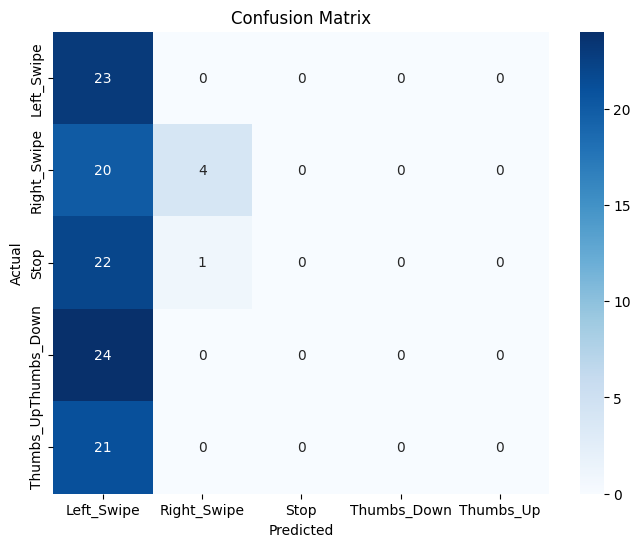


Classification Report:

              precision    recall  f1-score   support

  Left_Swipe       0.21      1.00      0.35        23
 Right_Swipe       0.80      0.17      0.28        24
        Stop       0.00      0.00      0.00        23
 Thumbs_Down       0.00      0.00      0.00        24
   Thumbs_Up       0.00      0.00      0.00        21

    accuracy                           0.23       115
   macro avg       0.20      0.23      0.12       115
weighted avg       0.21      0.23      0.13       115



C:\Users\rhmar\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\rhmar\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\rhmar\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [9]:
print("Starting evaluation...")

# Reload the model state (optional in a notebook, but good for verification)
model.load_state_dict(torch.load("mobilenet_model.pth", map_location=device))
model.eval()

y_true = []
y_pred = []

# Inference loop
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device, dtype=torch.float32)
        labels = labels.to(device)

        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 1. Accuracy
accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
print(f"\nValidation Accuracy: {accuracy:.2f}%\n")

# 2. Confusion Matrix
classes = val_dataset.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show() # Display in notebook
# plt.savefig("confusion_matrix.png") # Uncomment to save file

# 3. Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))